Using Ragas for evaluation: https://docs.ragas.io/en/latest/getstarted/index.html

In [ ]:
%pip install --upgrade pip

# Uninstall conflicting packages
%pip uninstall -y langchain-core langchain-openai langchain-experimental langchain-community langchain chromadb beautifulsoup4 python-dotenv PyPDF2 rank_bm25 ragas tqdm matplotlib 

# Install compatible versions of langchain-core and langchain-openai
%pip install langchain-core==0.3.6
%pip install langchain-openai==0.2.1
%pip install langchain-experimental==0.3.2
%pip install langchain-community==0.3.1
%pip install langchain==0.3.1

# Install remaining packages
%pip install chromadb==0.5.11
%pip install python-dotenv==1.0.1
%pip uninstall uvloop -y
%pip install PyPDF2==3.0.1 -q --user
%pip install rank_bm25==0.2.2

# new
%pip install ragas==0.1.20
%pip install tqdm==4.66.5 -q --user
%pip install matplotlib==3.9.2

# Restart the kernel after installation

In [8]:
import os
os.environ['USER_AGENT'] = 'RAGUserAgent'
import openai
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain import hub
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
import chromadb
from langchain_community.vectorstores import Chroma
from langchain_core.runnables import RunnableParallel
from dotenv import load_dotenv, find_dotenv
from langchain_core.prompts import PromptTemplate
from PyPDF2 import PdfReader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.docstore.document import Document
from langchain_community.retrievers import BM25Retriever
from langchain.retrievers import EnsembleRetriever

## new
import tqdm as notebook_tqdm
import pandas as pd
import matplotlib.pyplot as plt
from datasets import Dataset
from ragas import evaluate
from ragas.testset.generator import TestsetGenerator
from ragas.testset.evolutions import simple, reasoning, multi_context
from ragas.metrics import (
    answer_relevancy,
    faithfulness,
    context_recall,
    context_precision,
    answer_correctness,
    answer_similarity
)

In [9]:
# variables
_ = load_dotenv(dotenv_path='env.txt')
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY')
openai.api_key = os.environ['OPENAI_API_KEY']
embedding_function = OpenAIEmbeddings()
llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0)
pdf_path = "google-2023-environmental-report.pdf"
collection_name = "google_environmental_report"
str_output_parser = StrOutputParser()
user_query = "What are Google's environmental initiatives?"

In [10]:
# LLMs/Embeddings
embedding_ada = "text-embedding-ada-002"
model_gpt35="gpt-3.5-turbo"
model_gpt4="gpt-4o-mini"

embedding_function = OpenAIEmbeddings(model=embedding_ada, openai_api_key=openai.api_key)
llm = ChatOpenAI(model=model_gpt35, openai_api_key=openai.api_key, temperature=0.0)
generator_llm = ChatOpenAI(model=model_gpt35, openai_api_key=openai.api_key, temperature=0.0)
critic_llm = ChatOpenAI(model=model_gpt4, openai_api_key=openai.api_key, temperature=0.0)

In [11]:
#### INDEXING ####

In [12]:
# # Load the PDF and extract text
pdf_reader = PdfReader(pdf_path)
text = ""
for page in pdf_reader.pages:
    text += page.extract_text()

In [13]:
# Split
character_splitter = RecursiveCharacterTextSplitter(
    separators=["\n\n", "\n", ". ", " ", ""],
    chunk_size=1000,
    chunk_overlap=200
)
splits = character_splitter.split_text(text)

In [14]:
dense_documents = [Document(page_content=text, metadata={"id": str(i), "source": "dense"}) for i, text in enumerate(splits)]
sparse_documents = [Document(page_content=text, metadata={"id": str(i), "source": "sparse"}) for i, text in enumerate(splits)]

In [15]:
chroma_client = chromadb.Client()
vectorstore = Chroma.from_documents(
    documents=dense_documents,
    embedding=embedding_function,
    collection_name=collection_name,
    client=chroma_client
)

In [16]:
dense_retriever = vectorstore.as_retriever(search_kwargs={"k": 10})
sparse_retriever = BM25Retriever.from_documents(sparse_documents, k=10)
ensemble_retriever = EnsembleRetriever(retrievers=[dense_retriever, sparse_retriever], weights=[0.5, 0.5], c=0)

In [17]:
#### RETRIEVAL and GENERATION ####

In [19]:
# Prompt - ignore LangSmith warning, you will not need langsmith for this coding exercise
prompt = hub.pull("jclemens24/rag-prompt")

/opt/conda/lib/python3.11/site-packages/langsmith/client.py:323: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [20]:
# Relevance check prompt
relevance_prompt_template = PromptTemplate.from_template(
    """
    Given the following question and retrieved context, determine if the context is relevant to the question.
    Provide a score from 1 to 5, where 1 is not at all relevant and 5 is highly relevant.
    Return ONLY the numeric score, without any additional text or explanation.

    Question: {question}
    Retrieved Context: {retrieved_context}

    Relevance Score:"""
)

In [21]:
# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

In [22]:
def extract_score(llm_output):
    try:
        score = float(llm_output.strip())
        return score
    except ValueError:
        return 0

# Chain it all together with LangChain
def conditional_answer(x):
    relevance_score = extract_score(x['relevance_score'])
    if relevance_score < 4:
        return "I don't know."
    else:
        return x['answer']

In [23]:
rag_chain_from_docs = (
    RunnablePassthrough.assign(context=(lambda x: format_docs(x["context"])))
    | RunnableParallel(
        {"relevance_score": (
            RunnablePassthrough()
            | (lambda x: relevance_prompt_template.format(question=x['question'], retrieved_context=x['context']))
            | llm
            | str_output_parser
        ), "answer": (
            RunnablePassthrough()
            | prompt
            | llm
            | str_output_parser
        )}
    )
    | RunnablePassthrough().assign(final_answer=conditional_answer)
)

In [24]:
rag_chain_similarity = RunnableParallel(
    {"context": dense_retriever,
     "question": RunnablePassthrough()
}).assign(answer=rag_chain_from_docs)

In [25]:
rag_chain_hybrid = RunnableParallel(
    {"context": ensemble_retriever,
     "question": RunnablePassthrough()
}).assign(answer=rag_chain_from_docs)

In [26]:
# Question - Submitted to the similarity / dense vector search
result = rag_chain_similarity.invoke(user_query)
retrieved_docs = result['context']

print(f"Original Question to Similarity Search: {user_query}\n")
print(f"Relevance Score: {result['answer']['relevance_score']}\n")
print(f"Final Answer:\n{result['answer']['final_answer']}\n\n")
print("Retrieved Documents:")
for i, doc in enumerate(retrieved_docs, start=1):
    print(f"Document {i}: Document ID: {doc.metadata['id']} source: {doc.metadata['source']}")
    print(f"Content:\n{doc.page_content}\n")

Original Question to Similarity Search: What are Google's environmental initiatives?

Relevance Score: 5

Final Answer:
Google's environmental initiatives include empowering individuals to take action, working together with partners and customers, operating sustainably, achieving net-zero carbon emissions, focusing on water stewardship, and promoting a circular economy. They have set goals to help individuals and partners reduce carbon emissions, audited suppliers for environmental compliance, and supported various environmental projects and organizations. Additionally, Google is involved in public policy advocacy, industry initiatives like the iMasons Climate Accord, and sustainability-focused accelerators for startups.


Retrieved Documents:
Document 1: Document ID: 451 source: dense
Content:
Empowering individuals:  
A parking lot full of electric vehicles lined up outside a Google office, 
plugged into charging stations.
Working together:  
Satellite-derived Earth Engine image show

In [27]:
# Question - Submitted to the hybrid / multi-vector search
result = rag_chain_hybrid.invoke(user_query)
retrieved_docs = result['context']

print(f"Original Question to Dense Search: {user_query}\n")
print(f"Relevance Score: {result['answer']['relevance_score']}\n")
print(f"Final Answer:\n{result['answer']['final_answer']}\n\n")
print("Retrieved Documents:")
for i, doc in enumerate(retrieved_docs, start=1):
    print(f"Document {i}: Document ID: {doc.metadata['id']} source: {doc.metadata['source']}")
    print(f"Content:\n{doc.page_content}\n")

Original Question to Dense Search: What are Google's environmental initiatives?

Relevance Score: 5

Final Answer:
Google's environmental initiatives include empowering individuals to take action, working together with partners and customers, operating sustainably, achieving net-zero carbon emissions, focusing on water stewardship, engaging in a circular economy, and supporting sustainable consumption of public goods. Google also engages with suppliers to reduce energy consumption and greenhouse gas emissions, reports environmental data, and audits suppliers for compliance with environmental criteria. Additionally, Google is involved in various sustainability initiatives and partnerships, such as the iMasons Climate Accord, ReFED, and The Nature Conservancy. Google also invests in breakthrough innovation and supports sustainability-focused accelerators.


Retrieved Documents:
Document 1: Document ID: 451 source: dense
Content:
Empowering individuals:  
A parking lot full of electric ve

#### SIMILARITY SEARCH ONLY
Google's environmental initiatives include empowering individuals to take action, working together with partners and customers, operating sustainably, achieving net-zero carbon emissions, water stewardship, and promoting a circular economy. They have implemented sustainability features in products like Google Maps, Google Nest thermostats, and Google Flights to help individuals make more sustainable choices. Google also supports various environmental organizations and initiatives, such as the iMasons Climate Accord, ReFED, and The Nature Conservancy, to accelerate climate action and address environmental challenges. Additionally, Google is involved in public policy advocacy and is committed to reducing its environmental impact through its operations and value chain.


#### HYBRID SEARCH

Google's environmental initiatives include empowering individuals to take action, working together with partners and customers, operating sustainably, achieving net-zero carbon emissions, focusing on water stewardship, promoting a circular economy, engaging with suppliers to reduce energy consumption and greenhouse gas emissions, and reporting environmental data. They also support public policy and advocacy for low-carbon economies, participate in initiatives like the iMasons Climate Accord and ReFED, and support projects with organizations like The Nature Conservancy. Additionally, Google is involved in initiatives with the World Business Council for Sustainable Development and the World Resources Institute to improve well-being for people and the planet. They are also working on using technology and platforms to organize information about the planet and make it actionable to help partners and customers create a positive impact.

### SYNTHETIC DATA GENERATION

In [28]:
# generator with openai models
generator = TestsetGenerator.from_langchain(
    generator_llm,
    critic_llm,
    embedding_function
)

In [29]:
# Create a list of Document objects from the chunks
documents = [Document(page_content=chunk) for chunk in splits]

#### FOR FOLLOWING CODE: Uncomment and run once to generate source for test dataset! ####
# generate testset -
testset = generator.generate_with_langchain_docs(
    documents,
    test_size=10,
    distributions={
        simple: 0.5,
        reasoning: 0.25,
        multi_context: 0.25
    }
)

embedding nodes:   0%|          | 0/906 [00:00<?, ?it/s]

Filename and doc_id are the same for all nodes.


Generating:   0%|          | 0/10 [00:00<?, ?it/s]

In [30]:
# comparison dataframe
testset_df = testset.to_pandas()

# save dataframes to CSV files in the specified directory
testset_df.to_csv(os.path.join('testset_data.csv'), index=False)

print("testset DataFrame saved successfully in the local directory.")

testset DataFrame saved successfully in the local directory.


In [31]:
# pull data from saved testset, rather than generating above
### load dataframs from CSV file
saved_testset_df = pd.read_csv(os.path.join('testset_data.csv'))
print("testset DataFrame loaded successfully from local directory.")
saved_testset_df.head(5)

testset DataFrame loaded successfully from local directory.


,question,contexts,ground_truth,evolution_type,metadata,episode_done
0,How did Google prioritize the human experience...,"['Moving ahead, we’ll continue to build partne...",Google prioritized the human experience and co...,simple,[{}],True
1,How does the climate-conscious data center coo...,"['In 2022, we described our climate-conscious ...",The climate-conscious data center cooling stra...,simple,[{}],True
2,How does Google aim to promote sustainability ...,['that Google can make a meaningful difference...,Google aims to promote sustainability through ...,simple,[{}],True
3,What is Google's involvement in the iMasons Cl...,['iMasons Climate AccordGoogle is a founding m...,Google is a founding member and part of the go...,simple,[{}],True
4,What is the impact of the Rødby solar farm in ...,['0246\n2.49Scope 2 emissions \n(million tCO2e...,The impact of the Rødby solar farm in Denmark ...,simple,[{}],True


### PREPARE SIMILARITY SEARCH DATASET

In [32]:
# Convert the DataFrame to a dictionary
saved_testing_data = saved_testset_df.astype(str).to_dict(orient='list')

# Create the testing_dataset
saved_testing_dataset = Dataset.from_dict(saved_testing_data)

# Update the testing_dataset to include only these columns -
# "question", "ground_truth", "answer", "contexts"
saved_testing_dataset_sm = saved_testing_dataset.remove_columns(["evolution_type", "episode_done"])

In [33]:
saved_testing_dataset_sm

Dataset({
    features: ['question', 'contexts', 'ground_truth', 'metadata'],
    num_rows: 10
})

### EVAL SETS FOR EACH CHAIN

In [34]:
# Function to generate answers using the RAG chain
def generate_answer(question, ground_truth, rag_chain):
    result = rag_chain.invoke(question)
    return {
        "question": question,
        "answer": result["answer"]["final_answer"],
        "contexts": [doc.page_content for doc in result["context"]],
        "ground_truth": ground_truth
    }

In [35]:
# Add the "question", "answer", "contexts", and "ground_truth" to the testing_dataset
testing_dataset_similarity = saved_testing_dataset_sm.map(lambda x: generate_answer(x["question"], x["ground_truth"], rag_chain_similarity), remove_columns=saved_testing_dataset_sm.column_names)

Parameter 'function'=<function <lambda> at 0xffff604f1260> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/10 [00:00<?, ? examples/s]

In [36]:
# Add the "question", "answer", "contexts", and "ground_truth" to the testing_dataset
testing_dataset_hybrid = saved_testing_dataset_sm.map(lambda x: generate_answer(x["question"], x["ground_truth"], rag_chain_hybrid), remove_columns=saved_testing_dataset_sm.column_names)

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

### EVAL SCORING

In [37]:
# Similarity search score
score_similarity = evaluate(
    testing_dataset_similarity,
    metrics=[
        faithfulness,
        answer_relevancy,
        context_precision,
        context_recall,
        answer_correctness,
        answer_similarity
    ]
)
similarity_df = score_similarity.to_pandas()
similarity_df

Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

,question,contexts,answer,ground_truth,faithfulness,answer_relevancy,context_precision,context_recall,answer_correctness,answer_similarity
0,How did Google prioritize the human experience...,"[and nature\nWe invest for the long term, so w...",Google prioritized the human experience and co...,Google prioritized the human experience and co...,1.000000,0.997555,0.723299,1.0,0.870940,0.945323
1,How does the climate-conscious data center coo...,[85We’re working to achieve 24/7 CFE through t...,The climate-conscious data center cooling stra...,The climate-conscious data center cooling stra...,1.000000,0.947452,0.941518,1.0,0.804545,0.968317
2,How does Google aim to promote sustainability ...,[The opportunity we have through our products ...,Google aims to promote sustainability through ...,Google aims to promote sustainability through ...,1.000000,0.950937,0.895685,1.0,0.866854,0.951252
3,What is Google's involvement in the iMasons Cl...,[iMasons Climate AccordGoogle is a founding me...,Google is a founding member and part of the go...,Google is a founding member and part of the go...,1.000000,0.976704,0.906041,1.0,1.000000,0.999993
4,What is the impact of the Rødby solar farm in ...,[0246\n2.49Scope 2 emissions \n(million tCO2e)...,The impact of the Rødby solar farm in Denmark ...,The impact of the Rødby solar farm in Denmark ...,0.500000,1.000000,0.142857,1.0,0.732806,0.931228
5,How did Google work with CSIRO and Kaggle on a...,"[actions—like habitat restoration, increasing ...",Google worked with CSIRO and Kaggle on a machi...,Google collaborated with the Commonwealth Scie...,1.000000,0.922203,0.833333,1.0,0.634060,0.956822
6,What's the recycled aluminum percentage in new...,"[119 In 2020, we shared \nour next steps on th...",Approximately 30% of the material used in new ...,Recycled aluminum in the enclosures of new Goo...,1.000000,0.942914,0.355556,1.0,0.735437,0.941784
7,How has Google worked with BEF to support wate...,[and UN-Energy to help grow the movement to e...,Google has worked with the Bonneville Environm...,Google has partnered closely with Bonneville E...,1.000000,0.889455,0.878263,1.0,0.928335,0.986052
8,What environmental data does an independent au...,[Assurance\nWe obtain limited third-party assu...,The independent auditor reviews certain enviro...,An independent auditor reviews select environm...,0.571429,0.937679,0.891723,1.0,0.860406,0.971098
9,How many Olympic-sized swimming pools are equi...,[In addition to focusing on responsible water ...,The 271 million gallons of water replenished t...,The answer to given question is not present in...,1.000000,0.925566,0.000000,1.0,0.926240,0.705003


In [38]:
# similarity search score
score_hybrid = evaluate(
    testing_dataset_hybrid,
    metrics=[
        faithfulness,
        answer_relevancy,
        context_precision,
        context_recall,
        answer_correctness,
        answer_similarity
    ]
)
hybrid_df = score_hybrid.to_pandas()
hybrid_df

Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

,question,contexts,answer,ground_truth,faithfulness,answer_relevancy,context_precision,context_recall,answer_correctness,answer_similarity
0,How did Google prioritize the human experience...,"[Moving ahead, we’ll continue to build partner...",Google prioritized the human experience and co...,Google prioritized the human experience and co...,1.000000,0.998614,0.750027,1.000000,0.393038,0.940604
1,How does the climate-conscious data center coo...,"[In 2022, we described our climate-conscious d...",The climate-conscious data center cooling stra...,The climate-conscious data center cooling stra...,0.875000,0.961399,0.917785,0.666667,0.816331,0.979603
2,How does Google aim to promote sustainability ...,[The opportunity we have through our products ...,Google aims to promote sustainability through ...,Google aims to promote sustainability through ...,1.000000,0.950899,0.711978,1.000000,0.312600,0.950359
3,What is Google's involvement in the iMasons Cl...,[iMasons Climate AccordGoogle is a founding me...,Google is a founding member and part of the go...,Google is a founding member and part of the go...,1.000000,0.976760,0.899643,1.000000,0.745447,0.981677
4,What is the impact of the Rødby solar farm in ...,[0246\n2.49Scope 2 emissions \n(million tCO2e)...,The impact of the Rødby solar farm in Denmark ...,The impact of the Rødby solar farm in Denmark ...,0.333333,0.983809,0.333333,1.000000,0.684482,0.937928
5,How did Google work with CSIRO and Kaggle on a...,"[actions—like habitat restoration, increasing ...",Google worked with the Commonwealth Scientific...,Google collaborated with the Commonwealth Scie...,1.000000,0.922111,0.750000,1.000000,0.990879,0.963125
6,What's the recycled aluminum percentage in new...,"[119 In 2020, we shared \nour next steps on th...",Approximately 30% of the material used in new ...,Recycled aluminum in the enclosures of new Goo...,1.000000,0.942852,0.616835,1.000000,0.227186,0.908743
7,How has Google worked with BEF to support wate...,[and UN-Energy to help grow the movement to e...,Google has worked with the Bonneville Environm...,Google has partnered closely with Bonneville E...,1.000000,0.886091,0.904178,1.000000,0.887150,0.977181
8,What environmental data does an independent au...,[Assurance\nWe obtain limited third-party assu...,The independent auditor reviews certain enviro...,An independent auditor reviews select environm...,0.500000,0.899901,0.758791,1.000000,0.788278,0.971314
9,How many Olympic-sized swimming pools are equi...,[In addition to focusing on responsible water ...,More than 400 Olympic-sized swimming pools are...,The answer to given question is not present in...,1.000000,0.919425,0.000000,1.000000,0.674366,0.697480


### ANALYSIS

In [39]:
# Analysis that consolidates everything into easier-to-read scores
# key columns to compare
key_columns = [
    'faithfulness',
    'answer_relevancy',
    'context_precision',
    'context_recall',
    'answer_correctness',
    'answer_similarity'
]

# mean scores for each key column in similarity_df
similarity_means = similarity_df[key_columns].mean()

# mean scores for each key column in hybrid_df
hybrid_means = hybrid_df[key_columns].mean()

# comparison dataframe
comparison_df = pd.DataFrame({'Similarity Run': similarity_means, 'Hybrid Run': hybrid_means})

# difference between the means
comparison_df['Difference'] = comparison_df['Similarity Run'] - comparison_df['Hybrid Run']

# save dataframes to CSV files in the specified directory
similarity_df.to_csv(os.path.join('similarity_run_data.csv'), index=False)
hybrid_df.to_csv(os.path.join('hybrid_run_data.csv'), index=False)
comparison_df.to_csv(os.path.join('comparison_data.csv'), index=True)

print("Dataframes saved successfully in the local directory.")

Dataframes saved successfully in the local directory.


In [40]:
### load dataframes from CSV files
sem_df = pd.read_csv(os.path.join('similarity_run_data.csv'))
rec_df = pd.read_csv(os.path.join('hybrid_run_data.csv'))
comparison_df = pd.read_csv(os.path.join('comparison_data.csv'), index_col=0)

print("Dataframes loaded successfully from the local directory.")

# Analysis that consolidates everything into easier to read scores
print("Performance Comparison:")
print("\n**Retrieval**:")
print(comparison_df.loc[['context_precision', 'context_recall']])
print("\n**Generation**:")
print(comparison_df.loc[['faithfulness', 'answer_relevancy']])
print("\n**End-to-end evaluation**:")
print(comparison_df.loc[['answer_correctness', 'answer_similarity']])

Dataframes loaded successfully from the local directory.
Performance Comparison:

**Retrieval**:
                   Similarity Run  Hybrid Run  Difference
context_precision        0.656827    0.664257   -0.007430
context_recall           1.000000    0.966667    0.033333

**Generation**:
                  Similarity Run  Hybrid Run  Difference
faithfulness            0.907143    0.870833    0.036310
answer_relevancy        0.949047    0.944186    0.004861

**End-to-end evaluation**:
                    Similarity Run  Hybrid Run  Difference
answer_correctness        0.835962    0.651976    0.183987
answer_similarity         0.935687    0.930801    0.004886


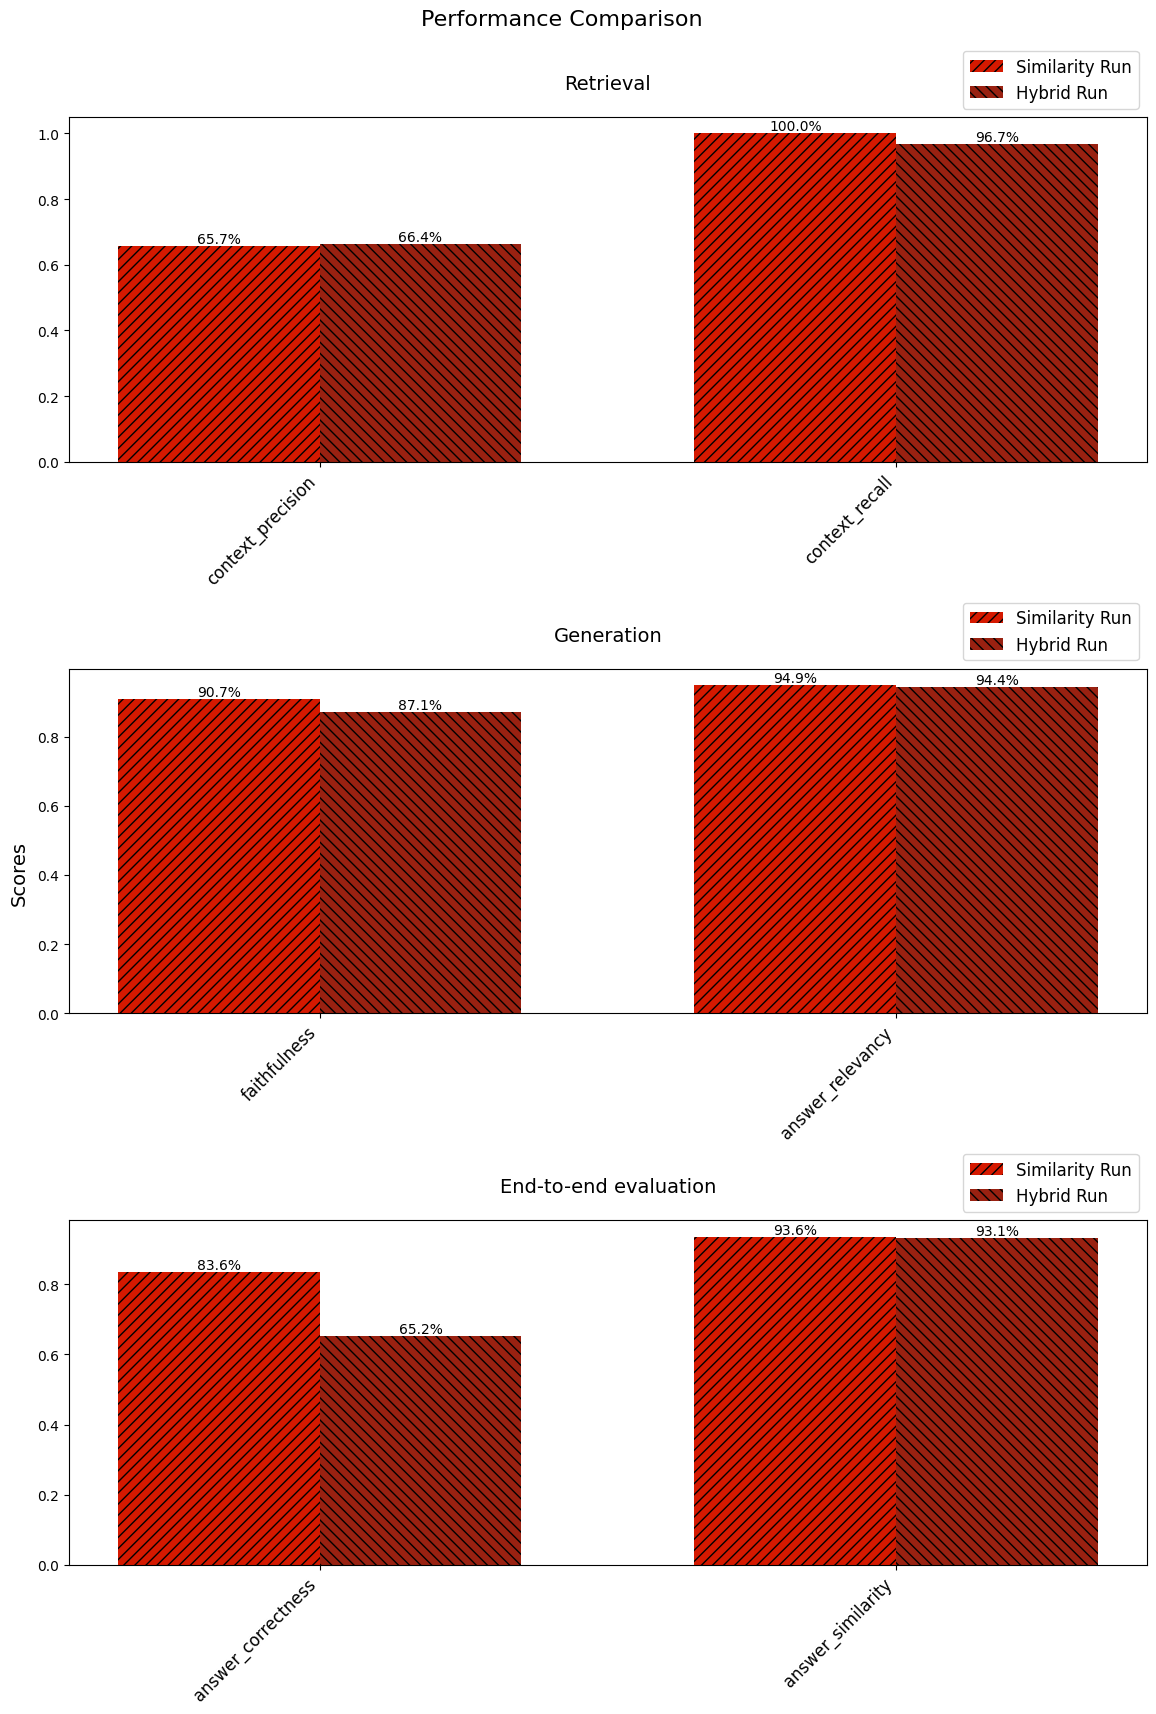

In [41]:
# plotting - create subplots for each category with increased spacing
fig, axes = plt.subplots(3, 1, figsize=(12, 18), sharex=False)
bar_width = 0.35
categories = ['Retrieval', 'Generation', 'End-to-end evaluation']
metrics = [
    ['context_precision', 'context_recall'],
    ['faithfulness', 'answer_relevancy'],
    ['answer_correctness', 'answer_similarity']
]

# iterate over each category and plot the corresponding metrics
for i, (category, metric_list) in enumerate(zip(categories, metrics)):
    ax = axes[i]
    x = range(len(metric_list))

    # plot bars for Similarity Run (hex color #D51900)
    similarity_bars = ax.bar(x, comparison_df.loc[metric_list, 'Similarity Run'], width=bar_width, label='Similarity Run', color='#D51900', hatch='///')

    # add values to Similarity Run bars
    for bar in similarity_bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.1%}', ha='center', va='bottom', fontsize=10)

    # plot bars for Hybrid Run (hex color #992111)
    hybrid_bars = ax.bar([i + bar_width for i in x], comparison_df.loc[metric_list, 'Hybrid Run'], width=bar_width, label='Hybrid Run', color='#992111', hatch='\\\\\\')

    # add values to Hybrid Run bars
    for bar in hybrid_bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.1%}', ha='center', va='bottom', fontsize=10)

    ax.set_title(category, fontsize=14, pad=20)
    ax.set_xticks([i + bar_width / 2 for i in x])
    ax.set_xticklabels(metric_list, rotation=45, ha='right', fontsize=12)

    # move the legend to the bottom right corner
    ax.legend(fontsize=12, loc='lower right', bbox_to_anchor=(1, 1))

# Add overall labels and title
fig.text(0.04, 0.5, 'Scores', va='center', rotation='vertical', fontsize=14)
fig.suptitle('Performance Comparison', fontsize=16)

# adjust the spacing between subplots and increase the top margin
plt.tight_layout(rect=[0.05, 0.03, 1, 0.95])
plt.subplots_adjust(hspace=0.6, top=0.92)
plt.show()